In [1]:
from keras.preprocessing.image import ImageDataGenerator , load_img , img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPool2D, Dense
import matplotlib.pyplot as plt

import numpy as np
from skimage import transform
import splitfolders
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

import splitfolders

In [3]:
splitfolders.ratio(
    "CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
   output="./dataset",
   seed=7,
   ratio=(0.90,0.050, 0.050)
)

Copying files: 12446 files [03:02, 68.03 files/s]


In [4]:
train_datagen = ImageDataGenerator(rescale=1/255)


train_dataset = train_datagen.flow_from_directory('./dataset/train',
                                                  target_size=(200, 200),
                                                  color_mode='grayscale', 
                                                  class_mode='categorical', 
                                                  batch_size=100,
                                                  )

Found 11200 images belonging to 4 classes.


In [5]:
valid_datagen = ImageDataGenerator(rescale=1/255)



valid_dataset = valid_datagen.flow_from_directory('./dataset/val',
                                                  target_size=(200, 200),
                                                  class_mode='categorical',
                                                  batch_size=100,
                                                  color_mode='grayscale',
                                                  )

Found 620 images belonging to 4 classes.


In [6]:

test_datagen = ImageDataGenerator(rescale=1/255)



test_dataset = test_datagen.flow_from_directory('./dataset/test',
                                                target_size=(200, 200),
                                                class_mode='categorical',
                                                color_mode='grayscale',
                                                batch_size=100,
                                                shuffle=False
                                                )


Found 626 images belonging to 4 classes.


In [8]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=train_dataset.image_shape))
model.add(Conv2D(32, (3,3), activation='relu'))

model.add(MaxPool2D(2))


model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))

model.add(MaxPool2D(2))


model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))

model.add(MaxPool2D(2))


model.add(Flatten())

model.add(Dense(512, activation='relu'))


model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 198, 198, 32)      320       
                                                                 
 conv2d_8 (Conv2D)           (None, 196, 196, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 98, 98, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_10 (Conv2D)          (None, 94, 94, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 47, 47, 64)        0         
 g2D)                                                 

In [9]:
import keras
METRICS = [
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
    
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=METRICS)

In [10]:
Info = model.fit(
                 train_dataset,
                 validation_data=valid_dataset,
                 epochs=5,
                 )

Epoch 1/5
112/112 [==============================] - 1781s 16s/step - loss: 1.0834 - accuracy: 0.5355 - precision: 0.6757 - recall: 0.3216 - val_loss: 0.7596 - val_accuracy: 0.7097 - val_precision: 0.7514 - val_recall: 0.6677
Epoch 2/5
112/112 [==============================] - 1320s 12s/step - loss: 0.3119 - accuracy: 0.8878 - precision: 0.9089 - recall: 0.8665 - val_loss: 0.0389 - val_accuracy: 0.9952 - val_precision: 0.9951 - val_recall: 0.9919
Epoch 3/5
112/112 [==============================] - 1267s 11s/step - loss: 0.0580 - accuracy: 0.9822 - precision: 0.9841 - recall: 0.9809 - val_loss: 0.0043 - val_accuracy: 0.9984 - val_precision: 0.9984 - val_recall: 0.9984
Epoch 4/5
112/112 [==============================] - 1269s 11s/step - loss: 0.0198 - accuracy: 0.9962 - precision: 0.9965 - recall: 0.9955 - val_loss: 0.0039 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/5
112/112 [==============================] - 1310s 12s/step - loss: 5.1976e-04 - accurac

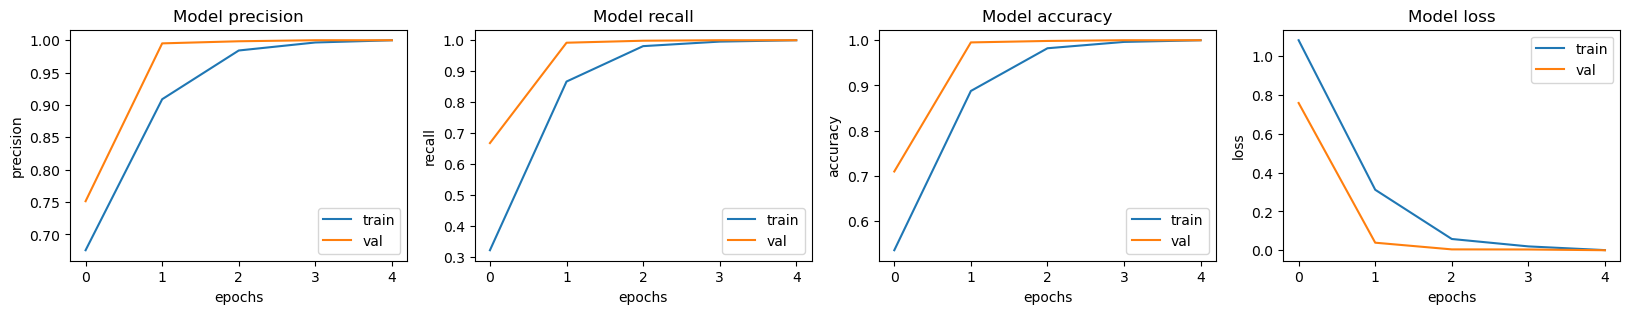

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(Info.history[met])
    ax[i].plot(Info.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [12]:
predictions = model.predict(test_dataset)


7/7 [==============================] - 15s 2s/step


In [13]:
diseases_labels = []

for key, value in train_dataset.class_indices.items():
   diseases_labels.append(key)

In [14]:
def evaluate(actual, predictions):
  pre = []
  for i in predictions:
    pre.append(np.argmax(i))

  accuracy = (pre == actual).sum() / actual.shape[0]
  print(f'Accuracy: {accuracy}')

  precision, recall, f1_score, _ = precision_recall_fscore_support(actual, pre, average='macro')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1_score: {f1_score}')

  fig, ax = plt.subplots(figsize=(20,20))
  conf_mat = confusion_matrix(actual, pre)
  sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap="YlGnBu", xticklabels=diseases_labels, yticklabels=diseases_labels).set_title('Confusion Matrix Heat map')
  plt.show()

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1_score: 1.0


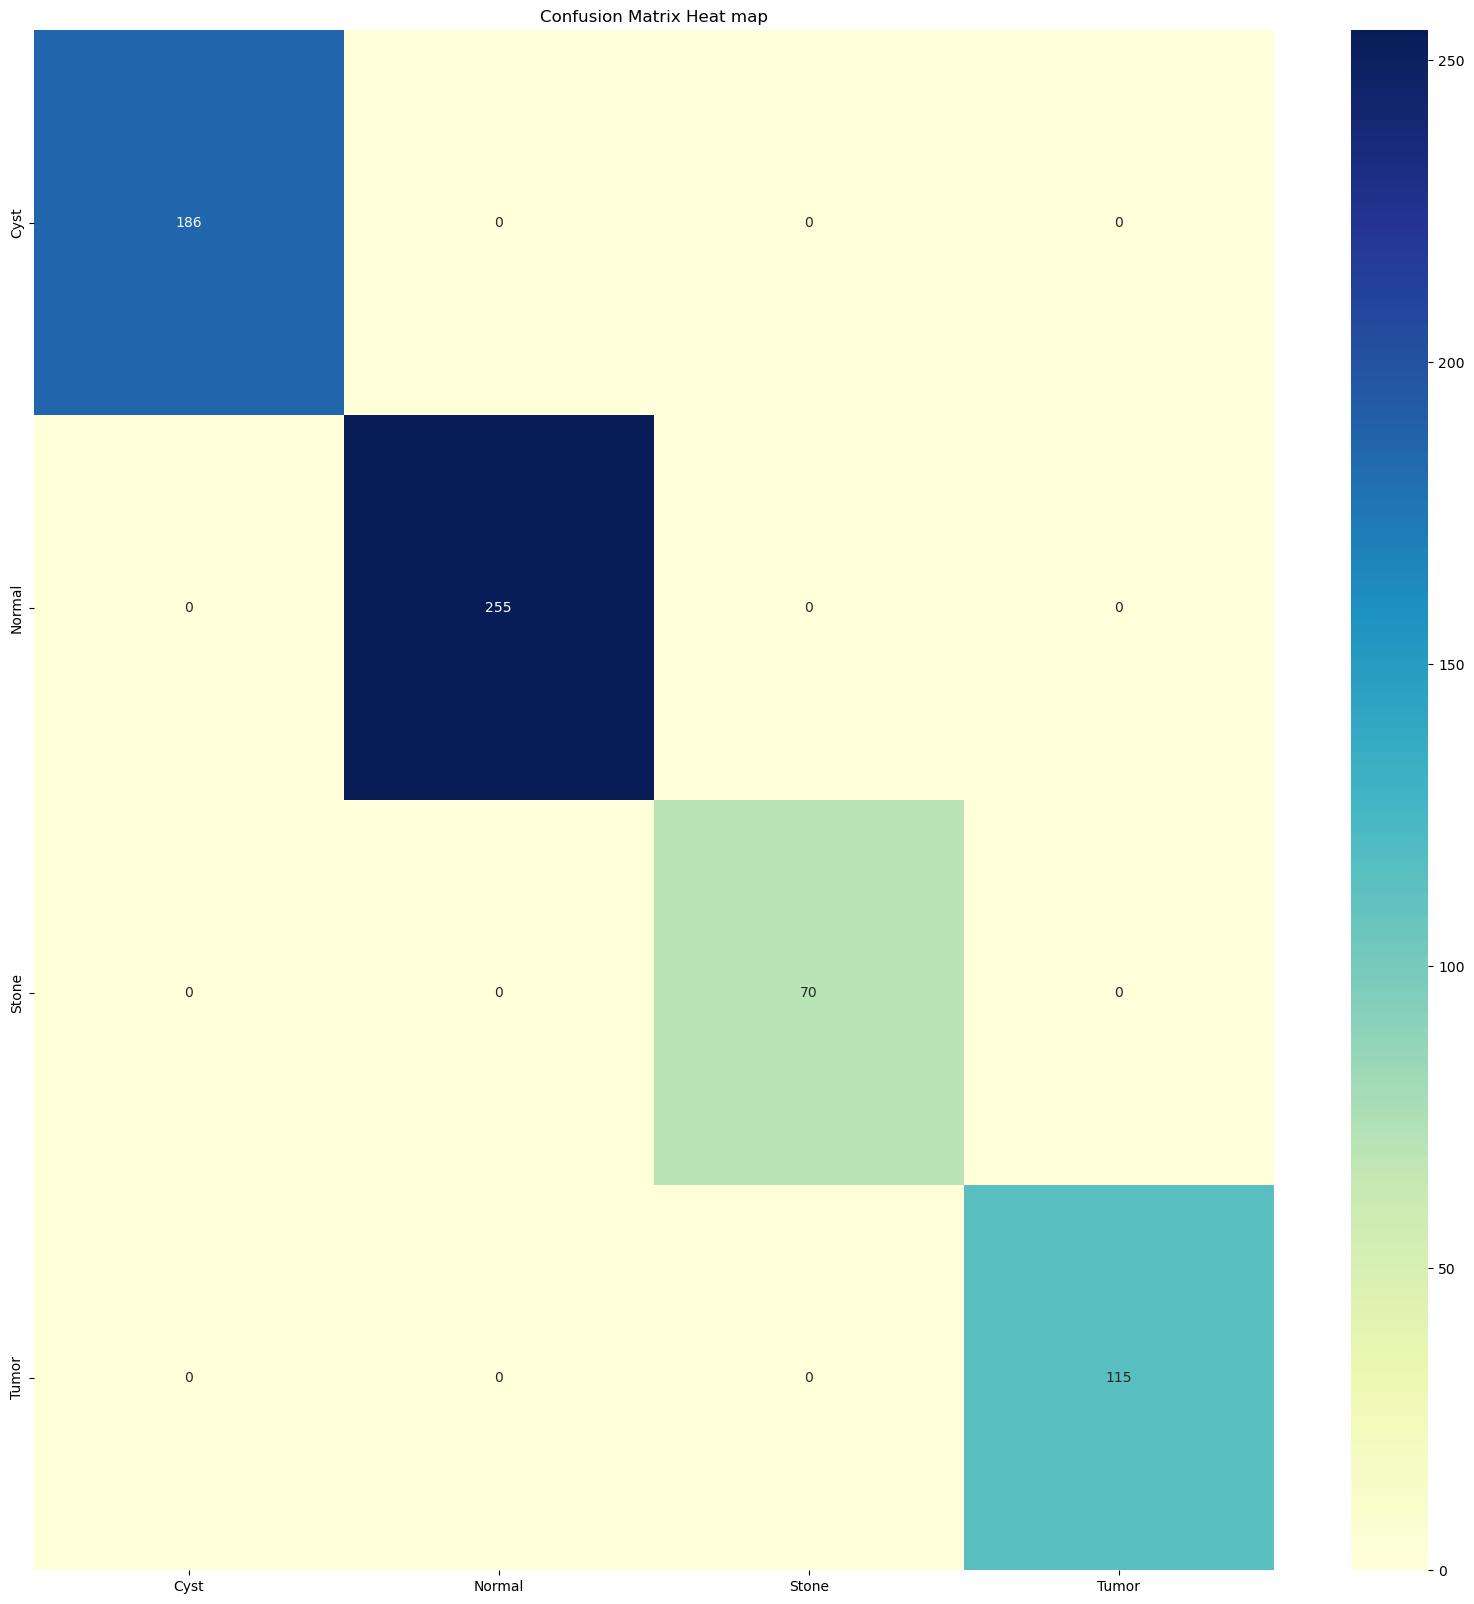

In [15]:
evaluate(test_dataset.classes,predictions)


In [16]:
model.evaluate(test_dataset)


7/7 [==============================] - 9s 1s/step - loss: 3.0619e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000


[3.061947427340783e-05, 1.0, 1.0, 1.0]